In [147]:
import pandas as pd
from sklearn import preprocessing
from pathlib import Path
from pandas.api.types import CategoricalDtype
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [148]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
                "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
                "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

In [149]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    # print(df[df['GarageYrBlt'].isnull()][['GarageYrBlt','YearBuilt']])
    # there are some NaN values in GarageYrBlt, so those NaN are going to be replaced by YearBuilt coloumn
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [150]:
def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [151]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [152]:
def load_data():
    # Read data
    data_dir = Path(".")
    df_train = pd.read_csv(data_dir / "train.csv",index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv",index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    print(df['OverallQual'])
    df = clean(df)
    df = encode(df)
    df = impute(df)
#   Reform splits
#   print(df.loc[df_train.index,:'MSZoning'])
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
#     print(df_test)
    return df_train, df_test


In [153]:
train,test = load_data()

Id
1       7
2       6
3       7
4       7
5       8
       ..
2915    4
2916    4
2917    5
2918    5
2919    7
Name: OverallQual, Length: 2919, dtype: int64


In [154]:

train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave  None      Reg   
2          20       RL         80.0     9600   Pave  None      Reg   
3          60       RL         68.0    11250   Pave  None      IR1   
4          70       RL         60.0     9550   Pave  None      IR1   
5          60       RL         84.0    14260   Pave  None      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0   None  None        None   
2          Lvl    AllPub       FR2  ...        0   None  None        None   
3          Lvl    AllPub    Inside  ...        0   None  None        None   
4          Lvl    AllPub    Corner  ...        0   None  None        None   
5          Lvl    AllPub       FR2  ...        0   None  None        None   

   MiscVal MoSold YrSold SaleType  SaleCondition  SalePrice  
Id                                                           
1        0      2   2008       WD         Normal   208500.0  
2        0      5   2007       WD         Normal   181500.0  
3        0      9   2008       WD         Normal   223500.0  
4        0      2   2006       WD        Abnorml   140000.0  
5        0     12   2008       WD         Normal   250000.0  

[5 rows x 80 columns]

In [155]:
# Establish e Baseline Score
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [156]:
X = train.copy()
y = X.pop("SalePrice")
#print(X['MSSubClass'])
baseline_score = score_dataset(X, y)
#print(X['MSSubClass'])
print(f"Baseline score: {baseline_score:.5f} RMSLE")


Baseline score: 0.14351 RMSLE


In [180]:
#feature Utility Score
def make_mi_scores(X, y):
    X = X.copy()
#     for colname in X.select_dtypes(["object", "category"]):
#          X[colname], _ = X[colname].factorize()
    for colname in X.select_dtypes(["category"]):
          X[colname] = X[colname].cat.codes
#   I found out surprisingly that, mi score doesn't change on nominal ordering or random factorize 
#   on categorical data. So the 2nd for loop(commented) also works
#   but for correlation, nominal ordering works better(2nd loop)



    # All discrete features should now have integer dtypes
    #discrete_features = X.dtypes == int
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    data_corr = X
    data_corr['SalePrice']=y
    data_corr = data_corr.corr()
    data_corr.sort_values(['SalePrice'], ascending=False, inplace=True)
    return data_corr,mi_scores
  #  return data_corr


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


SalePrice        1.000000
GrLivArea        0.708624
ExterQual        0.682639
KitchenQual      0.659600
GarageCars       0.640409
                   ...   
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Fence           -0.146942
MSZoning        -0.166872
GarageType      -0.415283
Name: SalePrice, Length: 80, dtype: float64


OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
MiscVal         0.000000
MiscFeature     0.000000
PoolQC          0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

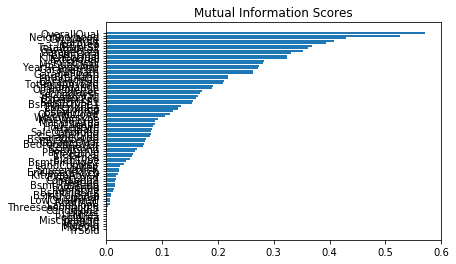

In [185]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
X = train.copy()
y = X.pop("SalePrice")

corr,mi_scores = make_mi_scores(X, y)
print(corr['SalePrice'])
plot_mi_scores(mi_scores)
mi_scores

In [186]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


In [187]:
X = train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.1433802572001567

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
MiscVal         0.000000
MiscFeature     0.000000
PoolQC          0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64